# Chapter 2: Temporal Evolution of Credit Risk Relationships

**Research Question**: *"Do credit risk relationships change across economic regimes, and how stable are ML model predictions over time?"*

## Motivation:
Financial crises reveal that credit risk models trained in stable periods may fail during stress. We investigate:
1. How feature importance evolves across economic regimes (2008-2023)
2. Whether risk relationships (ALE plots) shift during crises
3. Which features are **stable** vs **regime-dependent**

## Analysis Structure:
1. Define 5 economic periods (Financial Crisis → Post-COVID)
2. Train period-specific models (using preceding data)
3. Feature importance stability analysis
4. ALE plot evolution (threshold shifts)
5. Default rate evolution by feature quintiles

## Expected Contributions:
- First comprehensive study of ML credit model behavior across multiple economic regimes
- Quantify which risk factors amplify/dampen during crises
- Provide evidence on when models need retraining

---

In [1]:
import sys
from pathlib import Path
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import DEFAULT_PARAMS
from src.xai_utils import (
    calculate_shap_importance,
    compute_ale_1d,
    compute_performance_metrics,
    plot_interaction_heatmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis


## 1. Define Economic Periods

We analyze 5 distinct economic periods covering 2008-2023:

In [2]:
PERIODS = {
    'pre_crisis': (2004, 2006),
    'financial_crisis': (2008, 2010),
    'sovereign_debt': (2011, 2013),
    'recovery': (2014, 2018),
    'covid': (2020, 2021),
    'post_covid': (2022, 2023)
}

print("="*80)
print("ECONOMIC PERIODS FOR ANALYSIS")
print("="*80)
for period_name, (start, end) in PERIODS.items():
    print(f"  {period_name:20s}: {start}-{end}")
print("="*80)

ECONOMIC PERIODS FOR ANALYSIS
  pre_crisis          : 2004-2006
  financial_crisis    : 2008-2010
  sovereign_debt      : 2011-2013
  recovery            : 2014-2018
  covid               : 2020-2021
  post_covid          : 2022-2023


## 2. Load Data and Create Period-Specific Datasets

In [3]:
# Load full dataset
df_full = pd.read_parquet(FEATURE_CACHE_PATH)

# Apply same filters as global analysis
df = df_full[
    (df_full["ser_aktiv"] == 1) & 
    (df_full["sme_category"].isin(["Small", "Medium"])) & 
    (df_full["knc_kncfall"] == 1) &
    (df_full["bransch_borsbransch_konv"] != "40.0")
].copy()

print(f"Total dataset: {len(df):,} observations")
print(f"Date range: {df['ser_year'].min()} - {df['ser_year'].max()}")

# Check data availability for each period
print("\nData availability by period:")
for period_name, (start, end) in PERIODS.items():
    period_mask = (df['ser_year'] >= start) & (df['ser_year'] <= end)
    n_obs = period_mask.sum()
    print(f"  {period_name:20s}: {n_obs:>8,} observations ({n_obs/len(df)*100:>5.1f}%)")

Total dataset: 326,658 observations
Date range: 1998 - 2023

Data availability by period:
  pre_crisis          :   33,480 observations ( 10.2%)
  financial_crisis    :   36,250 observations ( 11.1%)
  sovereign_debt      :   35,978 observations ( 11.0%)
  recovery            :   61,386 observations ( 18.8%)
  covid               :   24,674 observations (  7.6%)
  post_covid          :   43,229 observations ( 13.2%)


In [4]:
# Create period-specific datasets
# Strategy: For each period, train on ALL data BEFORE the period, evaluate ON the period
# This simulates real deployment: model trained on historical data, tested on current conditions

period_data = {}

for period_name, (start, end) in PERIODS.items():
    # Training data: all years BEFORE this period
    train_mask = df['ser_year'] < start
    
    # Evaluation data: this period only
    eval_mask = (df['ser_year'] >= start) & (df['ser_year'] <= end)
    
    df_train_period = df[train_mask].copy()
    df_eval_period = df[eval_mask].copy()
    
    # Prepare modeling data
    if len(df_train_period) > 0 and len(df_eval_period) > 0:
        X_train, y_train = prepare_modeling_data(df_train_period)
        X_eval, y_eval = prepare_modeling_data(df_eval_period)
        
        period_data[period_name] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_eval': X_eval,
            'y_eval': y_eval,
            'train_years': (df['ser_year'].min(), start - 1),
            'eval_years': (start, end)
        }
        
        print(f"\n{period_name:20s}:")
        print(f"  Training:   {len(X_train):>8,} obs from {df['ser_year'].min()}-{start-1} (default rate: {y_train.mean()*100:.2f}%)")
        print(f"  Evaluation: {len(X_eval):>8,} obs from {start}-{end} (default rate: {y_eval.mean()*100:.2f}%)")
    else:
        print(f"\n⚠ {period_name}: Insufficient data")

print(f"\n✓ Created {len(period_data)} period-specific datasets")


pre_crisis          :
  Training:     66,681 obs from 1998-2003 (default rate: 2.14%)
  Evaluation:   33,467 obs from 2004-2006 (default rate: 1.32%)

financial_crisis    :
  Training:    112,522 obs from 1998-2007 (default rate: 1.92%)
  Evaluation:   36,226 obs from 2008-2010 (default rate: 1.91%)

sovereign_debt      :
  Training:    148,748 obs from 1998-2010 (default rate: 1.92%)
  Evaluation:   35,966 obs from 2011-2013 (default rate: 1.83%)

recovery            :
  Training:    184,714 obs from 1998-2013 (default rate: 1.90%)
  Evaluation:   61,344 obs from 2014-2018 (default rate: 1.65%)

covid               :
  Training:    258,576 obs from 1998-2019 (default rate: 1.82%)
  Evaluation:   24,659 obs from 2020-2021 (default rate: 1.70%)

post_covid          :
  Training:    283,235 obs from 1998-2021 (default rate: 1.81%)
  Evaluation:   20,914 obs from 2022-2023 (default rate: 1.07%)

✓ Created 6 period-specific datasets


## 3. Train Period-Specific Models

For each period, we train a LightGBM model on historical data and evaluate on that period.

In [5]:
# Train models for each period
period_models = {}
period_predictions = {}
period_shap = {}

for period_name, data in period_data.items():
    print(f"\n{'='*80}")
    print(f"Training model for {period_name.upper()}")
    print(f"{'='*80}")
    
    X_train = data['X_train']
    y_train = data['y_train']
    X_eval = data['X_eval']
    y_eval = data['y_eval']
    
    # Create train/val split for early stopping
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training on {len(X_tr):,} samples, validating on {len(X_val):,}...")
    
    # Use sklearn API (like in train.py)
    model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    
    # Fit with early stopping
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_names=['training', 'validation'],
        eval_metric='binary_logloss',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=50)
        ]
    )
    
    # Predict on evaluation period
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    
    # Evaluate
    metrics = compute_performance_metrics(y_eval, y_pred_proba)
    print(f"\nEvaluation on {period_name} ({data['eval_years'][0]}-{data['eval_years'][1]}):")
    print(f"  AUC:         {metrics['AUC']:.4f}")
    print(f"  PR-AUC:      {metrics['PR-AUC']:.4f}")
    print(f"  Brier Score: {metrics['Brier Score']:.4f}")
    print(f"  ECE:         {metrics['ECE']:.4f}")
    
    # Compute SHAP values on evaluation set (sample if too large)
    sample_size = min(5000, len(X_eval))
    if sample_size < len(X_eval):
        sample_idx = np.random.choice(len(X_eval), size=sample_size, replace=False)
        X_eval_sample = X_eval.iloc[sample_idx]
    else:
        X_eval_sample = X_eval
    
    print(f"\nComputing SHAP values on {len(X_eval_sample):,} samples...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval_sample)
    
    # Handle binary classification (returns list)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class
    
    print(f"  ✓ SHAP values computed (shape: {shap_values.shape})")
    
    # Store results
    period_models[period_name] = model
    period_predictions[period_name] = {
        'y_true': y_eval,
        'y_pred_proba': y_pred_proba,
        'metrics': metrics
    }
    period_shap[period_name] = {
        'shap_values': shap_values,
        'X_eval_sample': X_eval_sample,
        'feature_names': X_eval.columns.tolist()
    }

print(f"\n\n{'='*80}")
print(f"✓ Trained {len(period_models)} period-specific models")
print(f"{'='*80}")


Training model for PRE_CRISIS
Training on 53,344 samples, validating on 13,337...
[50]	training's binary_logloss: 0.0562411	validation's binary_logloss: 0.0762554
[100]	training's binary_logloss: 0.0437869	validation's binary_logloss: 0.0751491
[150]	training's binary_logloss: 0.0356663	validation's binary_logloss: 0.0751806

Evaluation on pre_crisis (2004-2006):
  AUC:         0.8980
  PR-AUC:      0.1523
  Brier Score: 0.0122
  ECE:         0.0051

Computing SHAP values on 5,000 samples...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  ✓ SHAP values computed (shape: (5000, 40))

Training model for FINANCIAL_CRISIS
Training on 90,017 samples, validating on 22,505...
[50]	training's binary_logloss: 0.0544868	validation's binary_logloss: 0.0750656
[100]	training's binary_logloss: 0.0443544	validation's binary_logloss: 0.0747584

Evaluation on financial_crisis (2008-2010):
  AUC:         0.8903
  PR-AUC:      0.1684
  Brier Score: 0.0173
  ECE:         0.0065

Computing SHAP values on 5,000 samples...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  ✓ SHAP values computed (shape: (5000, 40))

Training model for SOVEREIGN_DEBT
Training on 118,998 samples, validating on 29,750...
[50]	training's binary_logloss: 0.0580375	validation's binary_logloss: 0.0721855
[100]	training's binary_logloss: 0.0487362	validation's binary_logloss: 0.0712379
[150]	training's binary_logloss: 0.0426543	validation's binary_logloss: 0.0710809
[200]	training's binary_logloss: 0.0382595	validation's binary_logloss: 0.0712035

Evaluation on sovereign_debt (2011-2013):
  AUC:         0.9060
  PR-AUC:      0.2004
  Brier Score: 0.0161
  ECE:         0.0042

Computing SHAP values on 5,000 samples...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  ✓ SHAP values computed (shape: (5000, 40))

Training model for RECOVERY
Training on 147,771 samples, validating on 36,943...
[50]	training's binary_logloss: 0.0590219	validation's binary_logloss: 0.0709335
[100]	training's binary_logloss: 0.0507204	validation's binary_logloss: 0.0694469
[150]	training's binary_logloss: 0.0452693	validation's binary_logloss: 0.0692487
[200]	training's binary_logloss: 0.0410604	validation's binary_logloss: 0.0691791

Evaluation on recovery (2014-2018):
  AUC:         0.8954
  PR-AUC:      0.1655
  Brier Score: 0.0149
  ECE:         0.0048

Computing SHAP values on 5,000 samples...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  ✓ SHAP values computed (shape: (5000, 40))

Training model for COVID
Training on 206,860 samples, validating on 51,716...
[50]	training's binary_logloss: 0.059839	validation's binary_logloss: 0.0680081
[100]	training's binary_logloss: 0.0525649	validation's binary_logloss: 0.0667113
[150]	training's binary_logloss: 0.0474813	validation's binary_logloss: 0.0665712
[200]	training's binary_logloss: 0.0437484	validation's binary_logloss: 0.0665006

Evaluation on covid (2020-2021):
  AUC:         0.9050
  PR-AUC:      0.1821
  Brier Score: 0.0152
  ECE:         0.0059

Computing SHAP values on 5,000 samples...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  ✓ SHAP values computed (shape: (5000, 40))

Training model for POST_COVID
Training on 226,588 samples, validating on 56,647...
[50]	training's binary_logloss: 0.0599268	validation's binary_logloss: 0.0688065
[100]	training's binary_logloss: 0.0529626	validation's binary_logloss: 0.0674169
[150]	training's binary_logloss: 0.0482982	validation's binary_logloss: 0.067108
[200]	training's binary_logloss: 0.0446301	validation's binary_logloss: 0.0670102
[250]	training's binary_logloss: 0.0416038	validation's binary_logloss: 0.0670745

Evaluation on post_covid (2022-2023):
  AUC:         0.9070
  PR-AUC:      0.1305
  Brier Score: 0.0100
  ECE:         0.0053

Computing SHAP values on 5,000 samples...
  ✓ SHAP values computed (shape: (5000, 40))


✓ Trained 6 period-specific models


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## 4. Feature Importance Stability Analysis

### 4.1 Calculate SHAP Importance for Each Period

In [6]:
# Calculate feature importance for each period
importance_by_period = {}

for period_name, shap_data in period_shap.items():
    importance = calculate_shap_importance(
        shap_data['shap_values'],
        shap_data['feature_names']
    )
    importance_by_period[period_name] = importance.set_index('feature')['importance']

# Combine into single DataFrame
importance_evolution = pd.DataFrame(importance_by_period)
importance_evolution = importance_evolution.fillna(0)

# Calculate stability metrics
importance_evolution['mean'] = importance_evolution.mean(axis=1)
importance_evolution['std'] = importance_evolution[list(PERIODS.keys())].std(axis=1)
importance_evolution['cv'] = importance_evolution['std'] / importance_evolution['mean']
importance_evolution['cv'] = importance_evolution['cv'].replace([np.inf, -np.inf], np.nan)

# Sort by mean importance
importance_evolution = importance_evolution.sort_values('mean', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE EVOLUTION (Top 20 Features)")
print("="*80)
print(importance_evolution.head(20).to_string())
print("="*80)

# Identify stable vs volatile features
stable_features = importance_evolution[
    (importance_evolution['mean'] > importance_evolution['mean'].quantile(0.5)) &
    (importance_evolution['cv'] < 0.3)
].head(10)

volatile_features = importance_evolution[
    (importance_evolution['mean'] > importance_evolution['mean'].quantile(0.5)) &
    (importance_evolution['cv'] > 0.5)
].head(10)

print(f"\n✓ Stable features (high importance, low CV): {len(stable_features)}")
print(stable_features[['mean', 'cv']].to_string())

print(f"\n✓ Volatile features (high importance, high CV): {len(volatile_features)}")
print(volatile_features[['mean', 'cv']].to_string())

FEATURE IMPORTANCE EVOLUTION (Top 20 Features)
                         pre_crisis  financial_crisis  sovereign_debt  recovery     covid  post_covid      mean       std        cv
feature                                                                                                                            
dividend_yield             0.470829          0.644395        0.537879  0.515234  0.524149    0.485550  0.529673  0.061444  0.116004
sni_group_3digit           0.321144          0.251985        0.285389  0.301174  0.266793    0.276530  0.283836  0.024711  0.087062
ratio_cash_liquidity       0.223568          0.229712        0.278935  0.250715  0.206365    0.220717  0.235002  0.025923  0.110308
log_br07b_kabasu           0.148081          0.167275        0.175336  0.186456  0.353566    0.279803  0.218419  0.080590  0.368969
company_age                0.219601          0.149460        0.205612  0.224138  0.221173    0.232748  0.208789  0.030364  0.145429
ny_solid                   0.

### 4.2 Visualize Importance Evolution Heatmap

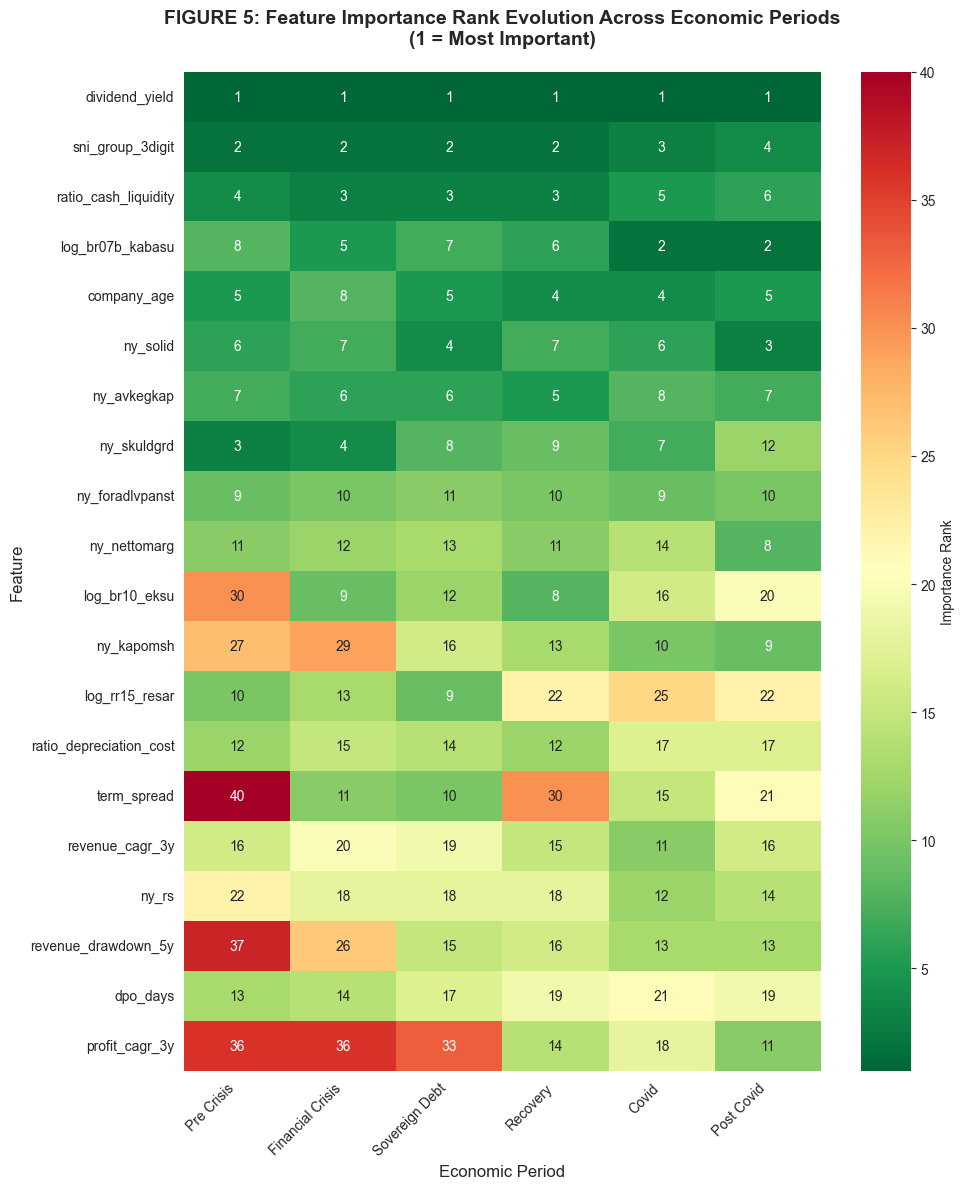


Reading the heatmap:
  • Green = Top ranked (most important)
  • Red = Lower ranked (less important)
  • Horizontal consistency = Stable importance
  • Color changes = Regime-dependent importance


In [7]:
# Create heatmap of feature importance ranks over time
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Get top 20 features by mean importance
top_20_features = importance_evolution.head(20).index.tolist()

# Create rank matrix
rank_matrix = pd.DataFrame(index=top_20_features, columns=list(PERIODS.keys()))
for period_name in PERIODS.keys():
    ranks = importance_evolution[period_name].rank(ascending=False)
    rank_matrix[period_name] = ranks[top_20_features]

# Plot heatmap
sns.heatmap(
    rank_matrix.astype(float),
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Importance Rank'},
    ax=ax,
    vmin=1,
    vmax=40
)

ax.set_title('FIGURE 5: Feature Importance Rank Evolution Across Economic Periods\n(1 = Most Important)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Economic Period', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_xticklabels([p.replace('_', ' ').title() for p in PERIODS.keys()], rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nReading the heatmap:")
print("  • Green = Top ranked (most important)")
print("  • Red = Lower ranked (less important)")
print("  • Horizontal consistency = Stable importance")
print("  • Color changes = Regime-dependent importance")

### 4.3 Performance Comparison Across Periods

TABLE: MODEL PERFORMANCE ACROSS ECONOMIC PERIODS
          Period      AUC   PR-AUC  Brier Score      ECE  Default Rate
      pre_crisis 0.898005 0.152303     0.012151 0.005099      0.013237
financial_crisis 0.890302 0.168398     0.017264 0.006459      0.019130
  sovereign_debt 0.905974 0.200414     0.016082 0.004223      0.018295
        recovery 0.895423 0.165540     0.014918 0.004815      0.016513
           covid 0.904984 0.182084     0.015217 0.005893      0.017032
      post_covid 0.907016 0.130509     0.009995 0.005315      0.010663


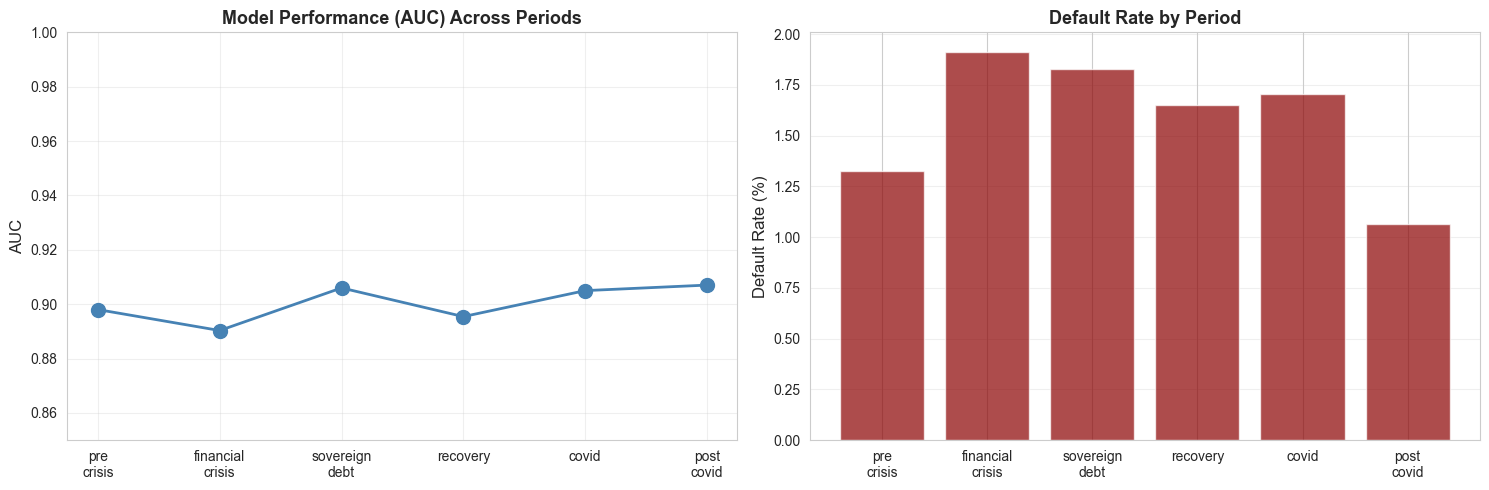

In [8]:
# Compare model performance across periods
performance_comparison = pd.DataFrame({
    'Period': list(PERIODS.keys()),
    'AUC': [period_predictions[p]['metrics']['AUC'] for p in PERIODS.keys()],
    'PR-AUC': [period_predictions[p]['metrics']['PR-AUC'] for p in PERIODS.keys()],
    'Brier Score': [period_predictions[p]['metrics']['Brier Score'] for p in PERIODS.keys()],
    'ECE': [period_predictions[p]['metrics']['ECE'] for p in PERIODS.keys()],
    'Default Rate': [period_predictions[p]['y_true'].mean() for p in PERIODS.keys()]
})

print("="*80)
print("TABLE: MODEL PERFORMANCE ACROSS ECONOMIC PERIODS")
print("="*80)
print(performance_comparison.to_string(index=False))
print("="*80)

# Visualize performance evolution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC over time
axes[0].plot(range(len(PERIODS)), performance_comparison['AUC'], 
             marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0].set_xticks(range(len(PERIODS)))
axes[0].set_xticklabels([p.replace('_', '\n') for p in PERIODS.keys()], fontsize=10)
axes[0].set_ylabel('AUC', fontsize=12)
axes[0].set_title('Model Performance (AUC) Across Periods', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.85, 1.0])

# Default rate over time
axes[1].bar(range(len(PERIODS)), performance_comparison['Default Rate'] * 100,
            color='darkred', alpha=0.7)
axes[1].set_xticks(range(len(PERIODS)))
axes[1].set_xticklabels([p.replace('_', '\n') for p in PERIODS.keys()], fontsize=10)
axes[1].set_ylabel('Default Rate (%)', fontsize=12)
axes[1].set_title('Default Rate by Period', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. ALE Plot Evolution (Threshold Shifts)

Investigate how risk relationships change across periods for key features.

In [9]:
# Select top 6 features for ALE evolution analysis
top_features_for_ale = importance_evolution.head(6).index.tolist()

# Remove categorical features
top_features_for_ale = [
    f for f in top_features_for_ale 
    if period_data[list(PERIODS.keys())[0]]['X_eval'][f].dtype != 'category'
]

print(f"Analyzing ALE evolution for {len(top_features_for_ale)} features:")
for i, f in enumerate(top_features_for_ale, 1):
    print(f"  {i}. {f}")

Analyzing ALE evolution for 5 features:
  1. dividend_yield
  2. ratio_cash_liquidity
  3. log_br07b_kabasu
  4. company_age
  5. ny_solid


In [10]:
# Compute ALE plots for each feature across periods
ale_evolution = {}

# Get all 40 features (exclude categorical)
all_features = [f for f in period_data[list(PERIODS.keys())[0]]['X_eval'].columns 
                if period_data[list(PERIODS.keys())[0]]['X_eval'][f].dtype != 'category']

print(f"Computing ALE evolution for all {len(all_features)} continuous features...")

for feature in all_features:
    print(f"\nComputing ALE evolution for {feature}...")
    ale_evolution[feature] = {}
    
    for period_name in PERIODS.keys():
        model = period_models[period_name]
        X_eval = period_data[period_name]['X_eval']
        
        try:
            # Use sklearn predict_proba instead of native predict
            predict_fn = lambda x: model.predict_proba(x)[:, 1]
            
            grid, ale, counts, bounds = compute_ale_1d(
                model,
                X_eval,
                feature,
                grid_size=40,
                predict_fn=predict_fn,
                percentile_range=(5, 95)
            )
            
            ale_evolution[feature][period_name] = {
                'grid': grid,
                'ale': ale,
                'counts': counts,
                'bounds': bounds
            }
        except Exception as e:
            print(f"  ⚠ Error for {period_name}: {e}")
            continue

print(f"\n✓ ALE evolution computed for {len(ale_evolution)} features")

Computing ALE evolution for all 39 continuous features...

Computing ALE evolution for company_age...

Computing ALE evolution for ny_kapomsh...

Computing ALE evolution for ny_rs...

Computing ALE evolution for ny_skuldgrd...

Computing ALE evolution for ny_solid...

Computing ALE evolution for ny_avkegkap...

Computing ALE evolution for ny_kasslikv...

Computing ALE evolution for ny_nettomarg...

Computing ALE evolution for ny_omspanst...

Computing ALE evolution for ny_foradlvpanst...

Computing ALE evolution for ny_omsf...

Computing ALE evolution for ny_anstf...

Computing ALE evolution for log_br10_eksu...

Computing ALE evolution for log_br07b_kabasu...

Computing ALE evolution for log_bslov_antanst...

Computing ALE evolution for log_rr15_resar...

Computing ALE evolution for ratio_depreciation_cost...

Computing ALE evolution for ratio_cash_interest_cov...

Computing ALE evolution for ratio_cash_liquidity...

Computing ALE evolution for ratio_short_term_debt_share...

Computin

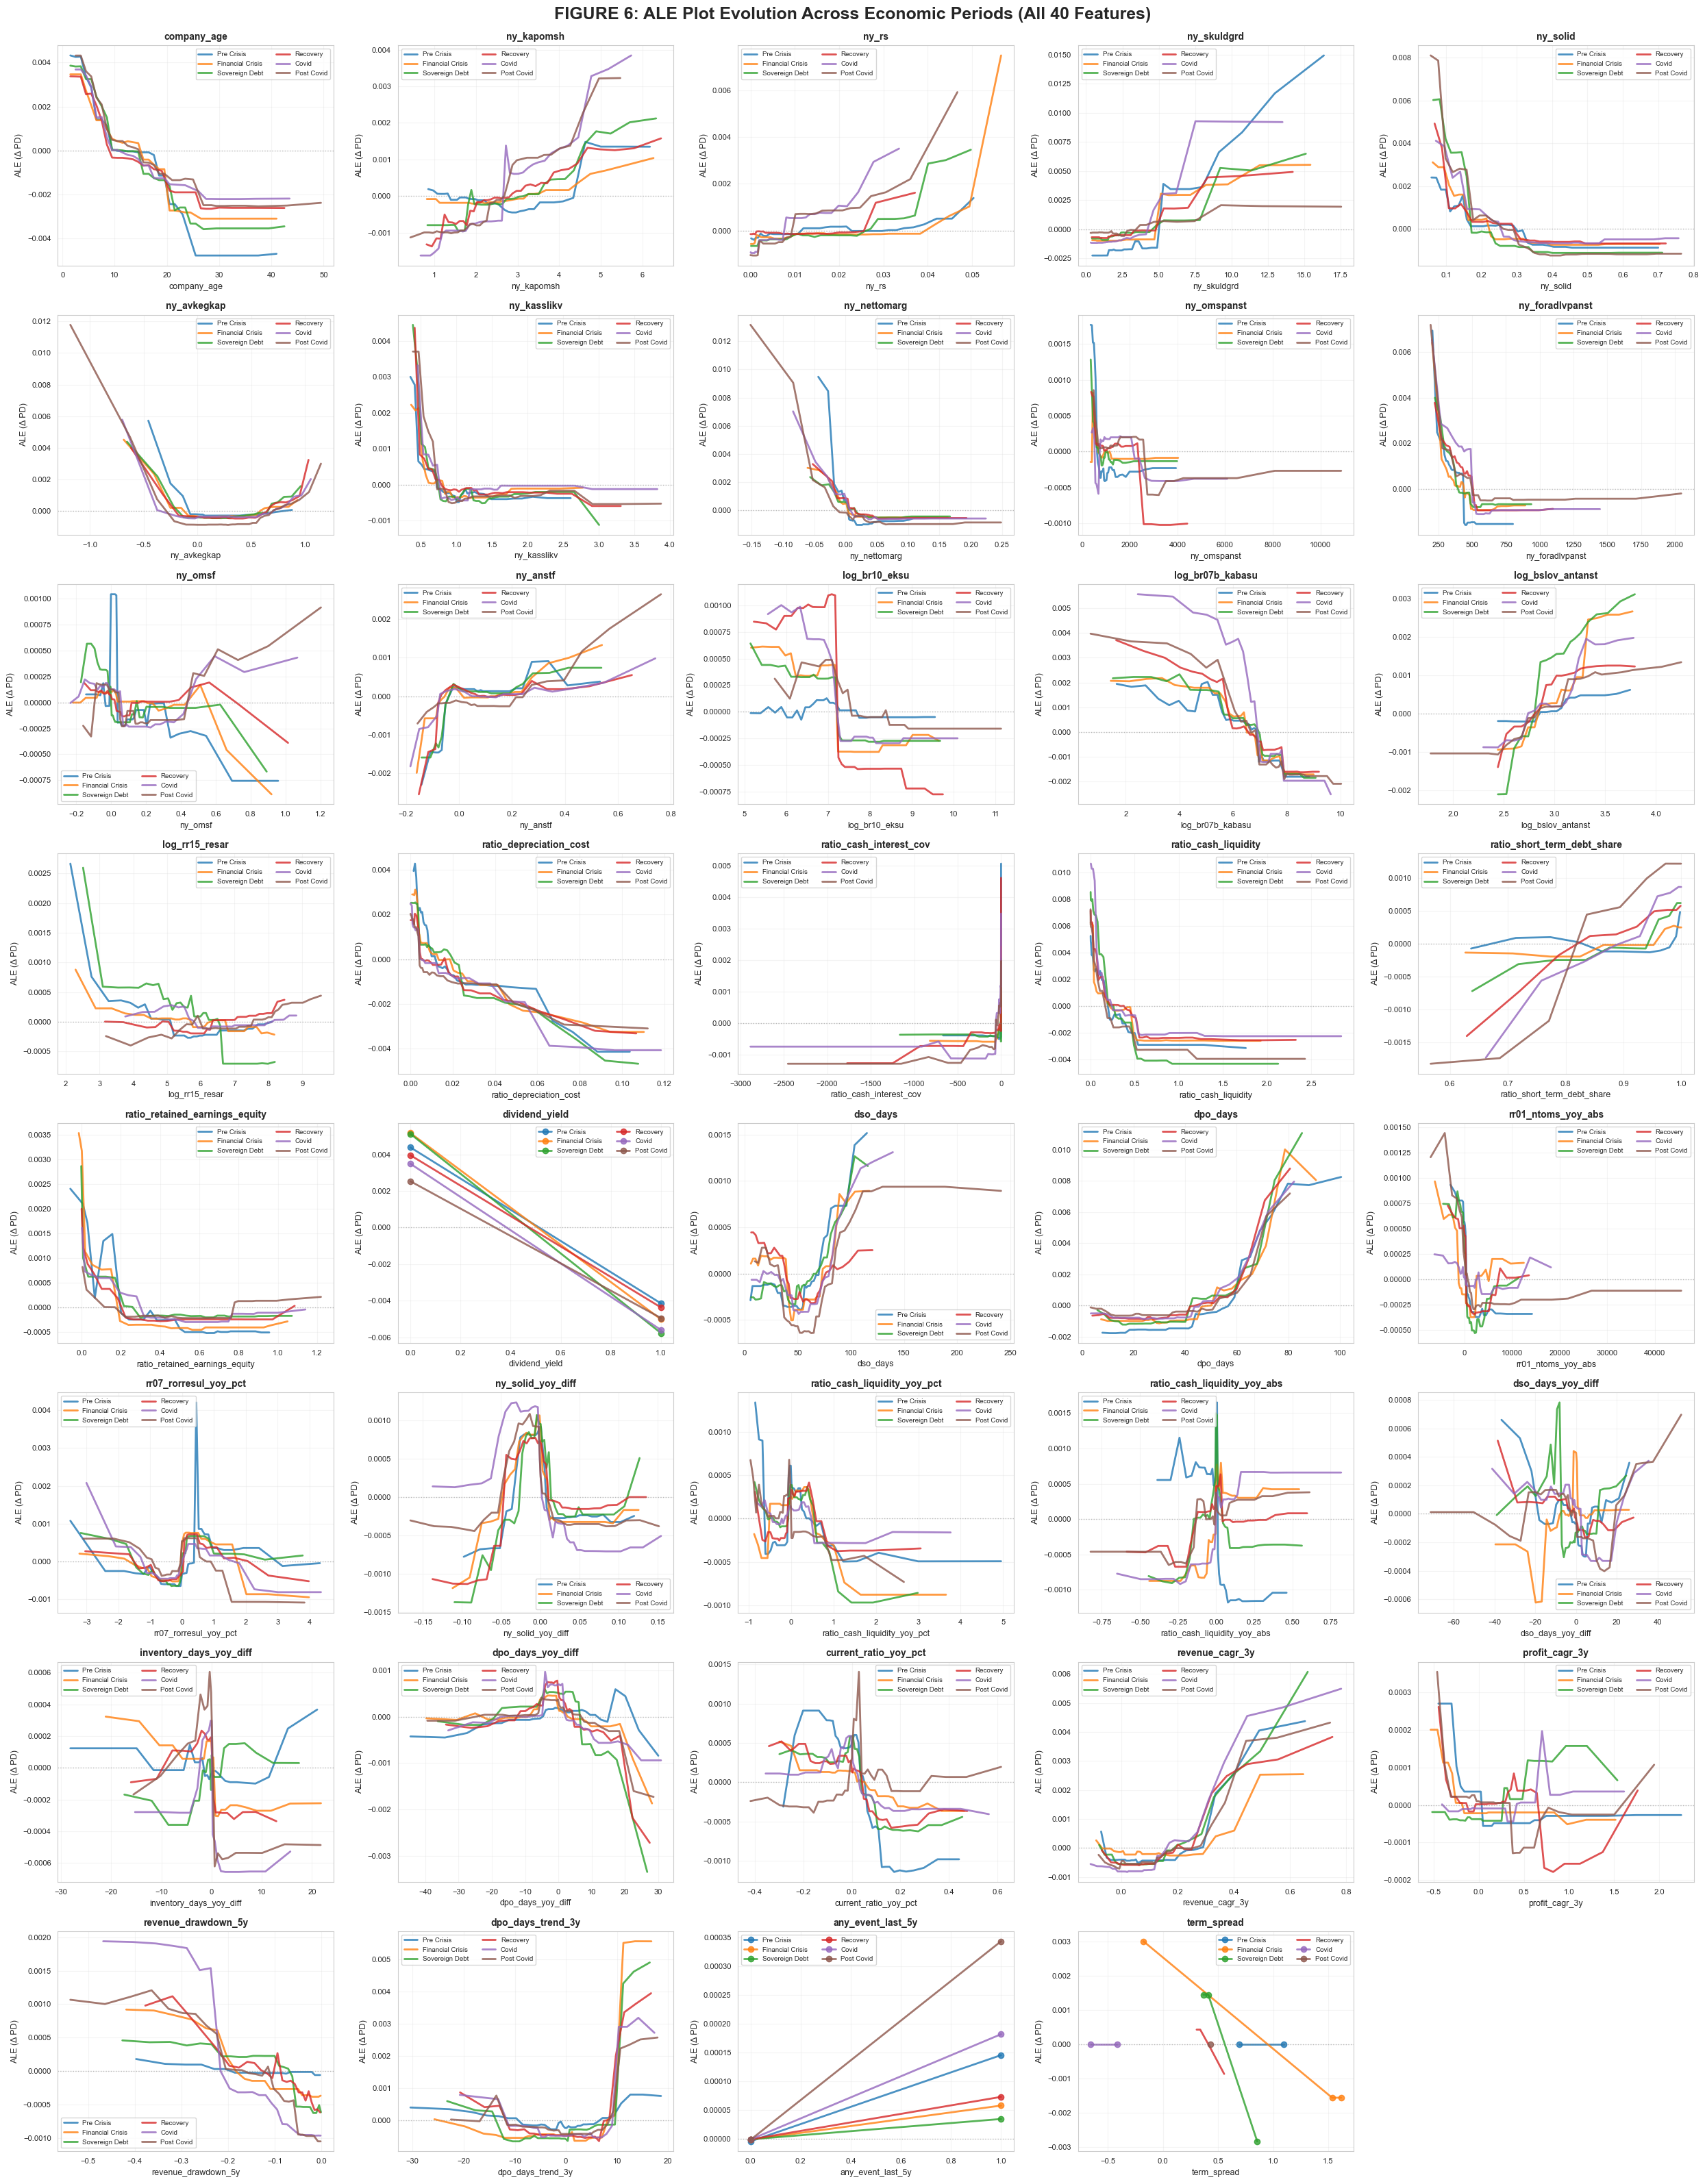


Reading the ALE evolution plots:
  • Each line color represents a different economic period
  • Parallel lines = Stable relationship across regimes
  • Diverging lines = Relationship changes during crises
  • Shift in inflection points = Threshold shifts
  • Total features visualized: 39


In [11]:
# Visualize ALE evolution for ALL features
n_features = len(ale_evolution)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

# Define distinct colors for each period
period_colors = {
    'pre_crisis': '#1f77b4',      # Blue
    'financial_crisis': '#ff7f0e', # Orange
    'sovereign_debt': '#2ca02c',   # Green
    'recovery': '#d62728',         # Red
    'covid': '#9467bd',            # Purple
    'post_covid': '#8c564b'        # Brown
}
period_labels = {k: k.replace('_', ' ').title() for k in PERIODS.keys()}

for idx, (feature, period_ales) in enumerate(ale_evolution.items()):
    ax = axes[idx]
    
    # Track if we plotted anything
    plotted_any = False
    
    for period_name, ale_data in period_ales.items():
        if len(ale_data['grid']) > 0 and len(ale_data['ale']) > 0:
            is_binary = len(ale_data['grid']) <= 3
            
            ax.plot(
                ale_data['grid'],
                ale_data['ale'],
                label=period_labels[period_name],
                linewidth=2.0,
                color=period_colors[period_name],
                marker='o' if is_binary else None,
                markersize=6,
                alpha=0.8
            )
            plotted_any = True
    
    if plotted_any:
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel('ALE (Δ PD)', fontsize=9)
        ax.set_title(f'{feature}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=7, loc='best', ncol=2)
        ax.grid(alpha=0.2)
        ax.tick_params(labelsize=8)
    else:
        # No data plotted
        ax.text(0.5, 0.5, f'{feature}\n(No variation)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=9)
        ax.set_title(feature, fontsize=10, fontweight='bold')

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('FIGURE 6: ALE Plot Evolution Across Economic Periods (All 40 Features)',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nReading the ALE evolution plots:")
print("  • Each line color represents a different economic period")
print("  • Parallel lines = Stable relationship across regimes")
print("  • Diverging lines = Relationship changes during crises")
print("  • Shift in inflection points = Threshold shifts")
print(f"  • Total features visualized: {n_features}")

## 6. Feature Importance Evolution Over Time

Visualize how SHAP importance changes across economic periods for all features.

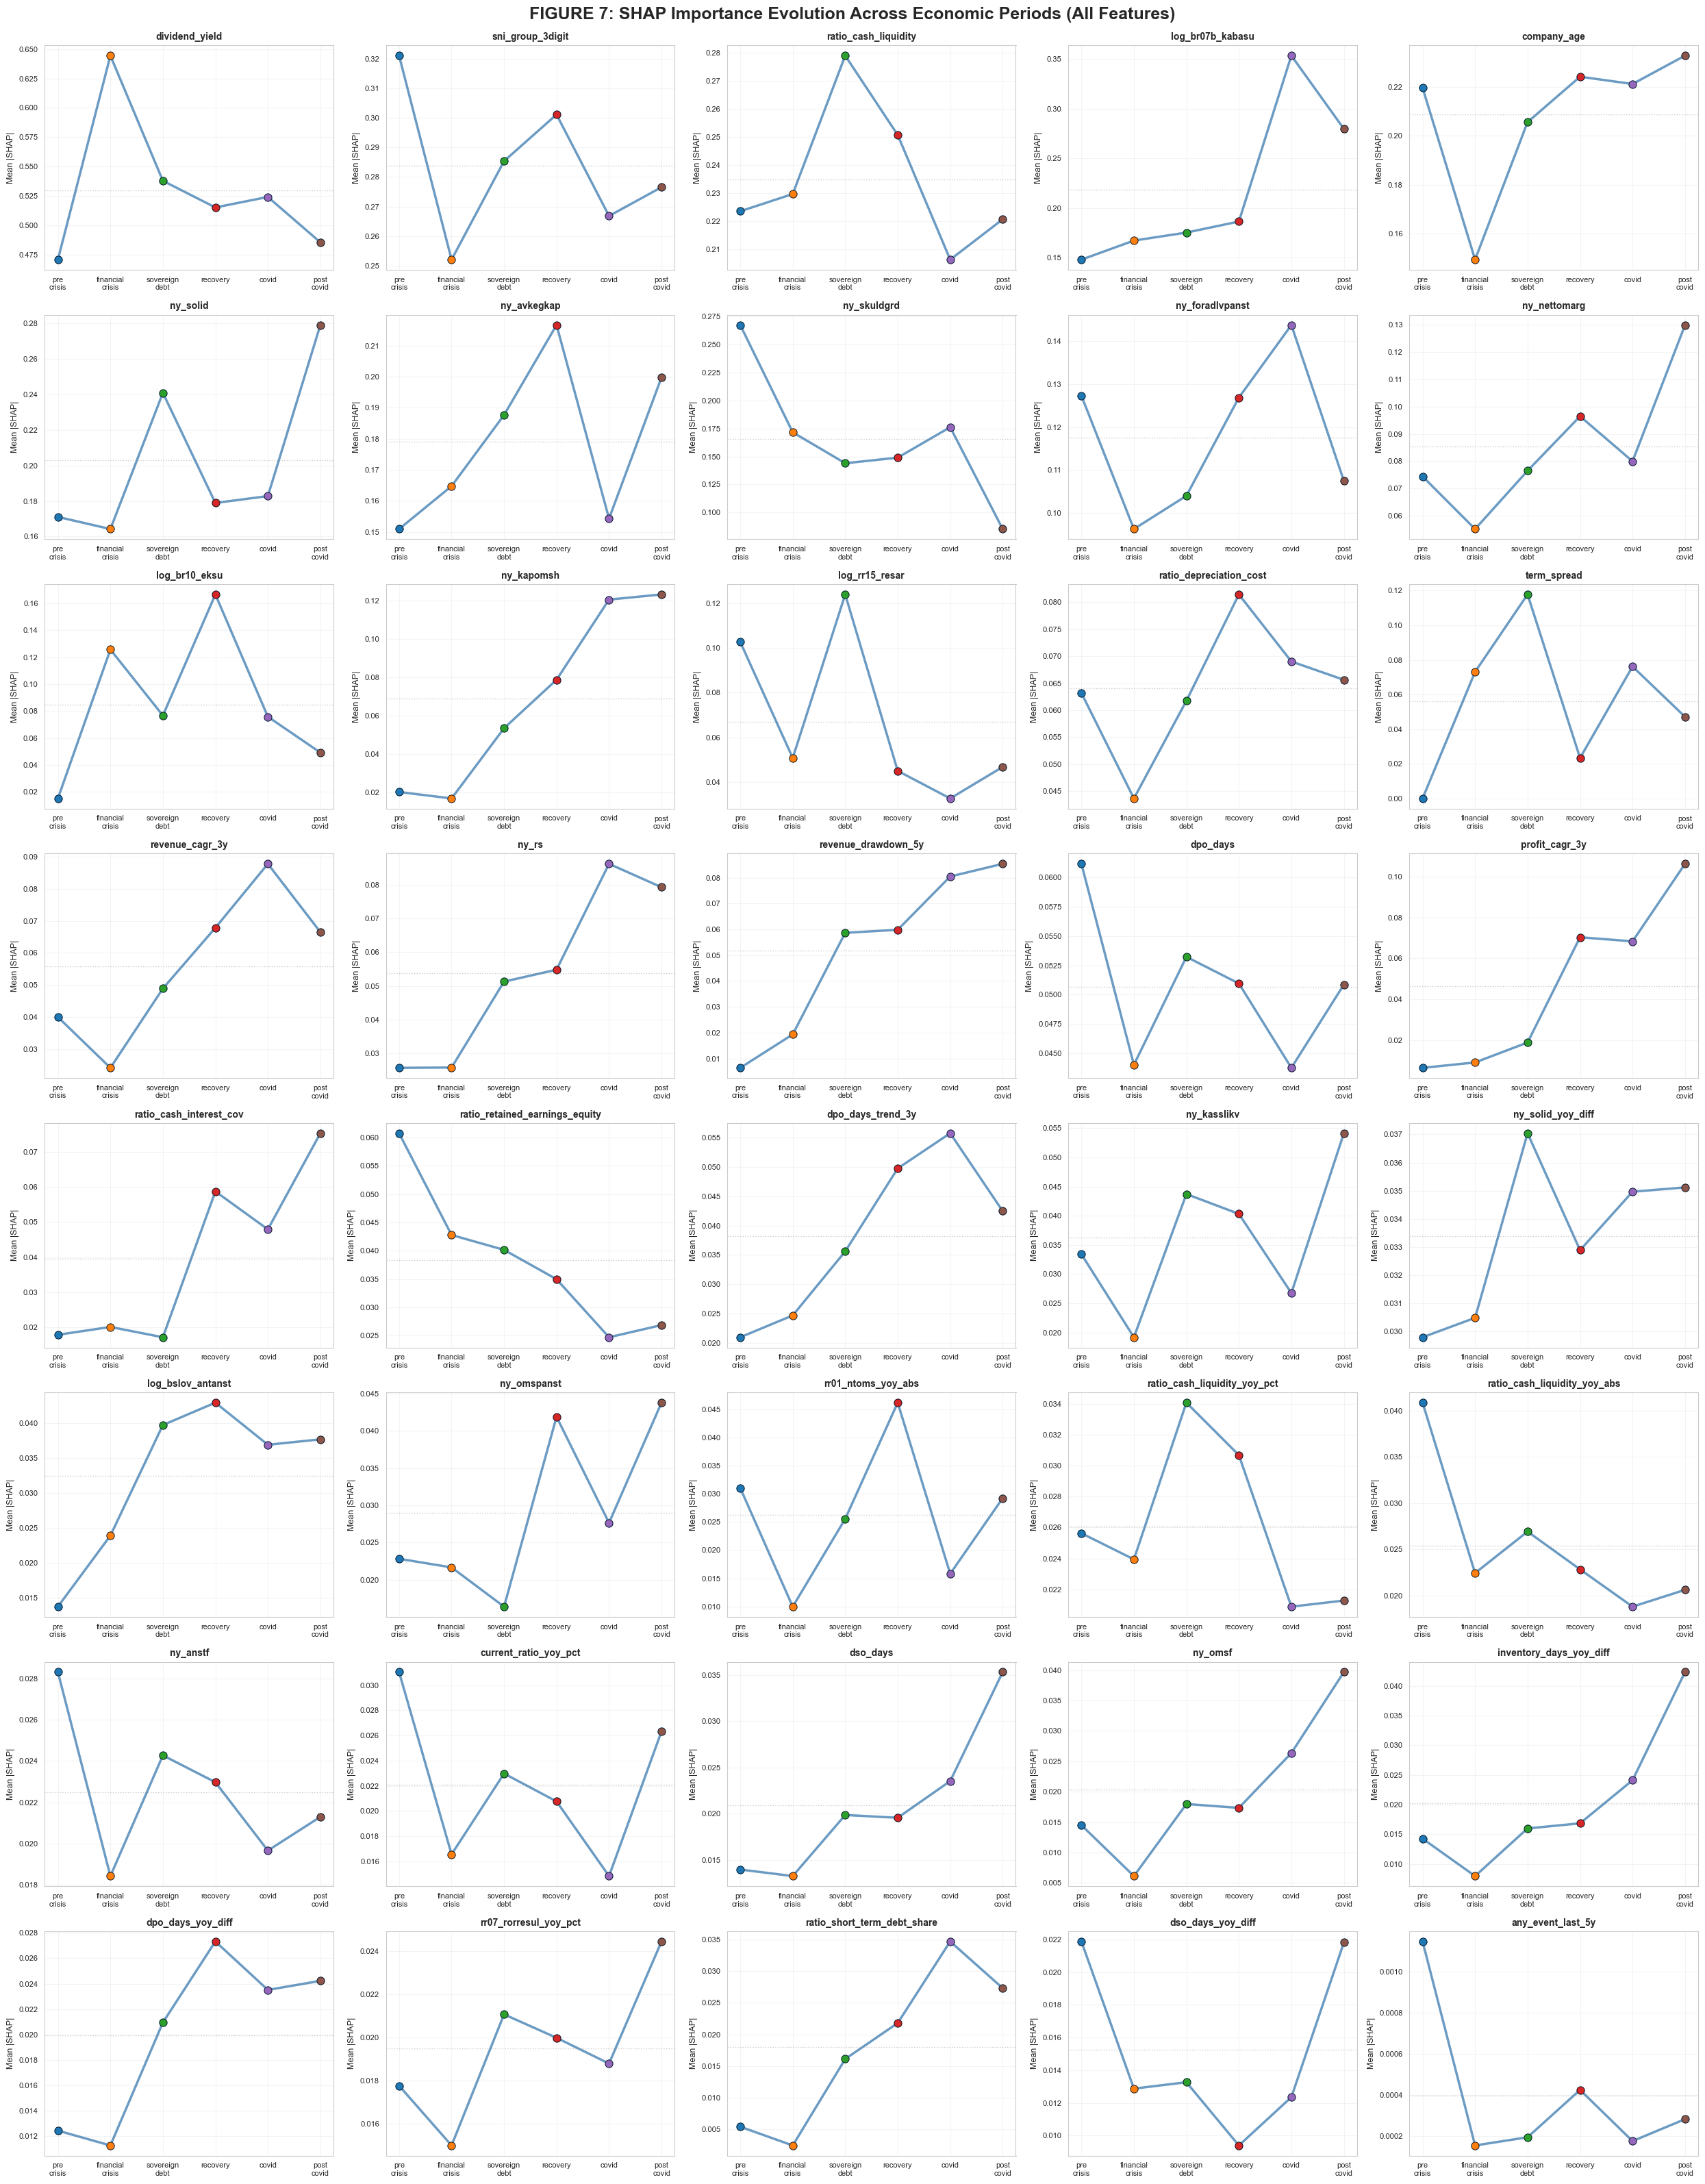


Reading the importance evolution plots:
  • Flat lines = Stable importance across regimes
  • Upward spikes = Feature becomes more important during that period
  • Downward dips = Feature becomes less important
  • Colored markers show each economic period
  • Dotted line = Mean importance across all periods

✓ Visualized 40 features across 6 periods


In [12]:
# Plot SHAP importance evolution for all 40 features
n_features = len(importance_evolution)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
axes = axes.flatten()

# Period labels and x positions
period_names = list(PERIODS.keys())
x_positions = np.arange(len(period_names))

# Define distinct colors for each period (same as ALE plots)
period_colors = {
    'pre_crisis': '#1f77b4',
    'financial_crisis': '#ff7f0e',
    'sovereign_debt': '#2ca02c',
    'recovery': '#d62728',
    'covid': '#9467bd',
    'post_covid': '#8c564b'
}

for idx, (feature, row) in enumerate(importance_evolution.iterrows()):
    ax = axes[idx]
    
    # Get importance values for each period
    importance_values = [row[p] for p in period_names]
    
    # Plot line with markers
    ax.plot(x_positions, importance_values, 
            marker='o', linewidth=2.5, markersize=8,
            color='steelblue', alpha=0.8)
    
    # Color the markers by period
    for i, period in enumerate(period_names):
        ax.plot(i, importance_values[i], 'o', 
                markersize=8, color=period_colors[period], 
                markeredgecolor='black', markeredgewidth=0.5)
    
    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels([p.replace('_', '\n') for p in period_names], 
                        fontsize=7, rotation=0)
    ax.set_ylabel('Mean |SHAP|', fontsize=9)
    ax.set_title(f'{feature}', fontsize=10, fontweight='bold')
    ax.grid(alpha=0.2)
    ax.tick_params(labelsize=8)
    
    # Add horizontal line at mean to show stability
    mean_importance = np.mean(importance_values)
    ax.axhline(y=mean_importance, color='gray', linestyle=':', linewidth=1, alpha=0.4)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('FIGURE 7: SHAP Importance Evolution Across Economic Periods (All Features)',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nReading the importance evolution plots:")
print("  • Flat lines = Stable importance across regimes")
print("  • Upward spikes = Feature becomes more important during that period")
print("  • Downward dips = Feature becomes less important")
print("  • Colored markers show each economic period")
print(f"  • Dotted line = Mean importance across all periods")
print(f"\n✓ Visualized {n_features} features across {len(period_names)} periods")

## 6. Grouped Feature Importance Analysis

**Problem**: Individual feature importance is noisy due to limited samples per period. 
**Solution**: Aggregate features into economically meaningful groups to identify systematic patterns.

Based on the feature documentation (engineered_features.md), we group features into:
1. **Profitability** - Margins, returns on capital
2. **Liquidity** - Cash ratios, quick ratios
3. **Leverage** - Debt structure, solvency
4. **Growth/Momentum** - YoY changes, CAGRs
5. **Working Capital** - DSO, DPO, inventory efficiency
6. **Scale** - Size proxies (log-transformed nominals)
7. **Behavioral** - Dividend policy, credit history
8. **Macro** - Term spread (economic conditions)

In [13]:
# Define economically meaningful feature groups
# Based on engineered_features.md and config.py documentation

FEATURE_GROUPS = {
    'Profitability': [
        'ny_avkegkap',          # Return on equity
        'ny_nettomarg',         # Net margin  
        'ny_foradlvpanst',      # Value added per employee
        'ny_omspanst',          # Revenue per employee
        'rr07_rorresul_yoy_pct', # Operating profit YoY change
        'profit_cagr_3y',       # 3-year profit growth
    ],
    'Liquidity': [
        'ratio_cash_liquidity',      # Quick ratio (cash vs current liab)
        'ny_kasslikv',               # Cash liquidity ratio
        'log_br07b_kabasu',          # Log cash and bank
        'ratio_cash_interest_cov',   # Cash interest coverage
        'ratio_cash_liquidity_yoy_pct',  # Liquidity trend %
        'ratio_cash_liquidity_yoy_abs',  # Liquidity trend abs
    ],
    'Leverage': [
        'ny_skuldgrd',                    # Debt-to-equity
        'ny_solid',                       # Equity-to-assets
        'ny_rs',                          # Interest rate on debt
        'ratio_short_term_debt_share',    # Short-term debt share
        'ratio_retained_earnings_equity', # Retained earnings composition
        'ny_solid_yoy_diff',              # Solvency trend
    ],
    'Growth_Momentum': [
        'ny_omsf',                  # Revenue growth YoY %
        'rr01_ntoms_yoy_abs',       # Revenue growth absolute
        'revenue_cagr_3y',          # 3-year revenue CAGR
        'revenue_drawdown_5y',      # Revenue resilience (drawdown)
        'ny_anstf',                 # Employee growth
        'current_ratio_yoy_pct',    # Current ratio trend
    ],
    'Working_Capital': [
        'dso_days',              # Days sales outstanding
        'dpo_days',              # Days payables outstanding
        'dso_days_yoy_diff',     # DSO trend
        'dpo_days_yoy_diff',     # DPO trend
        'inventory_days_yoy_diff', # Inventory efficiency trend
        'dpo_days_trend_3y',     # Long-term supplier payment trend
    ],
    'Scale_Industry': [
        'log_br10_eksu',         # Log equity (size proxy)
        'log_bslov_antanst',     # Log employees (size proxy)
        'log_rr15_resar',        # Log net profit
        'sni_group_3digit',      # Industry code
        'company_age',           # Firm age
        'ny_kapomsh',            # Asset turnover
    ],
    'Behavioral': [
        'dividend_yield',        # Dividend policy signal
        'any_event_last_5y',     # Credit event history
        'ratio_depreciation_cost', # Capital intensity proxy
    ],
    'Macro': [
        'term_spread',           # Yield curve (economic conditions)
    ],
}

# Verify all features are assigned
all_grouped_features = [f for group in FEATURE_GROUPS.values() for f in group]
all_model_features = importance_evolution.index.tolist()

# Check for unassigned features
unassigned = [f for f in all_model_features if f not in all_grouped_features]
assigned_but_missing = [f for f in all_grouped_features if f not in all_model_features]

print("="*80)
print("FEATURE GROUP DEFINITIONS")
print("="*80)
for group, features in FEATURE_GROUPS.items():
    present = [f for f in features if f in all_model_features]
    print(f"\n{group}: {len(present)} features")
    for f in features:
        status = "✓" if f in all_model_features else "✗ (not in model)"
        print(f"  {status} {f}")

if unassigned:
    print(f"\n⚠ Unassigned features ({len(unassigned)}): {unassigned}")
if assigned_but_missing:
    print(f"\n⚠ Defined but not in model ({len(assigned_but_missing)}): {assigned_but_missing}")

FEATURE GROUP DEFINITIONS

Profitability: 6 features
  ✓ ny_avkegkap
  ✓ ny_nettomarg
  ✓ ny_foradlvpanst
  ✓ ny_omspanst
  ✓ rr07_rorresul_yoy_pct
  ✓ profit_cagr_3y

Liquidity: 6 features
  ✓ ratio_cash_liquidity
  ✓ ny_kasslikv
  ✓ log_br07b_kabasu
  ✓ ratio_cash_interest_cov
  ✓ ratio_cash_liquidity_yoy_pct
  ✓ ratio_cash_liquidity_yoy_abs

Leverage: 6 features
  ✓ ny_skuldgrd
  ✓ ny_solid
  ✓ ny_rs
  ✓ ratio_short_term_debt_share
  ✓ ratio_retained_earnings_equity
  ✓ ny_solid_yoy_diff

Growth_Momentum: 6 features
  ✓ ny_omsf
  ✓ rr01_ntoms_yoy_abs
  ✓ revenue_cagr_3y
  ✓ revenue_drawdown_5y
  ✓ ny_anstf
  ✓ current_ratio_yoy_pct

Working_Capital: 6 features
  ✓ dso_days
  ✓ dpo_days
  ✓ dso_days_yoy_diff
  ✓ dpo_days_yoy_diff
  ✓ inventory_days_yoy_diff
  ✓ dpo_days_trend_3y

Scale_Industry: 6 features
  ✓ log_br10_eksu
  ✓ log_bslov_antanst
  ✓ log_rr15_resar
  ✓ sni_group_3digit
  ✓ company_age
  ✓ ny_kapomsh

Behavioral: 3 features
  ✓ dividend_yield
  ✓ any_event_last_5y
  ✓ 

In [14]:
# Compute grouped importance by summing SHAP importance within each group
grouped_importance = pd.DataFrame(index=FEATURE_GROUPS.keys(), columns=list(PERIODS.keys()))

for period_name in PERIODS.keys():
    for group_name, features in FEATURE_GROUPS.items():
        # Only include features that exist in the model
        valid_features = [f for f in features if f in importance_evolution.index]
        if valid_features:
            # Sum the importance of all features in the group
            group_total = importance_evolution.loc[valid_features, period_name].sum()
            grouped_importance.loc[group_name, period_name] = group_total
        else:
            grouped_importance.loc[group_name, period_name] = 0

# Convert to float
grouped_importance = grouped_importance.astype(float)

# Add summary statistics
grouped_importance['mean'] = grouped_importance[list(PERIODS.keys())].mean(axis=1)
grouped_importance['std'] = grouped_importance[list(PERIODS.keys())].std(axis=1)
grouped_importance['cv'] = grouped_importance['std'] / grouped_importance['mean']

# Sort by mean importance
grouped_importance = grouped_importance.sort_values('mean', ascending=False)

print("="*80)
print("GROUPED FEATURE IMPORTANCE BY ECONOMIC PERIOD")
print("="*80)
print("\nTotal SHAP importance by group (summed across features in group):")
print(grouped_importance.round(3).to_string())
print("="*80)

GROUPED FEATURE IMPORTANCE BY ECONOMIC PERIOD

Total SHAP importance by group (summed across features in group):
                 pre_crisis  financial_crisis  sovereign_debt  recovery  covid  post_covid   mean    std     cv
Scale_Industry        0.692             0.619           0.785     0.859  0.754       0.766  0.746  0.082  0.110
Behavioral            0.535             0.688           0.600     0.597  0.593       0.551  0.594  0.053  0.090
Liquidity             0.489             0.483           0.576     0.590  0.674       0.672  0.581  0.084  0.144
Leverage              0.560             0.437           0.530     0.472  0.539       0.533  0.512  0.047  0.091
Profitability         0.400             0.362           0.425     0.572  0.493       0.612  0.477  0.099  0.208
Growth_Momentum       0.151             0.095           0.198     0.235  0.245       0.268  0.199  0.065  0.329
Working_Capital       0.145             0.114           0.159     0.174  0.183       0.217  0.165  0.03

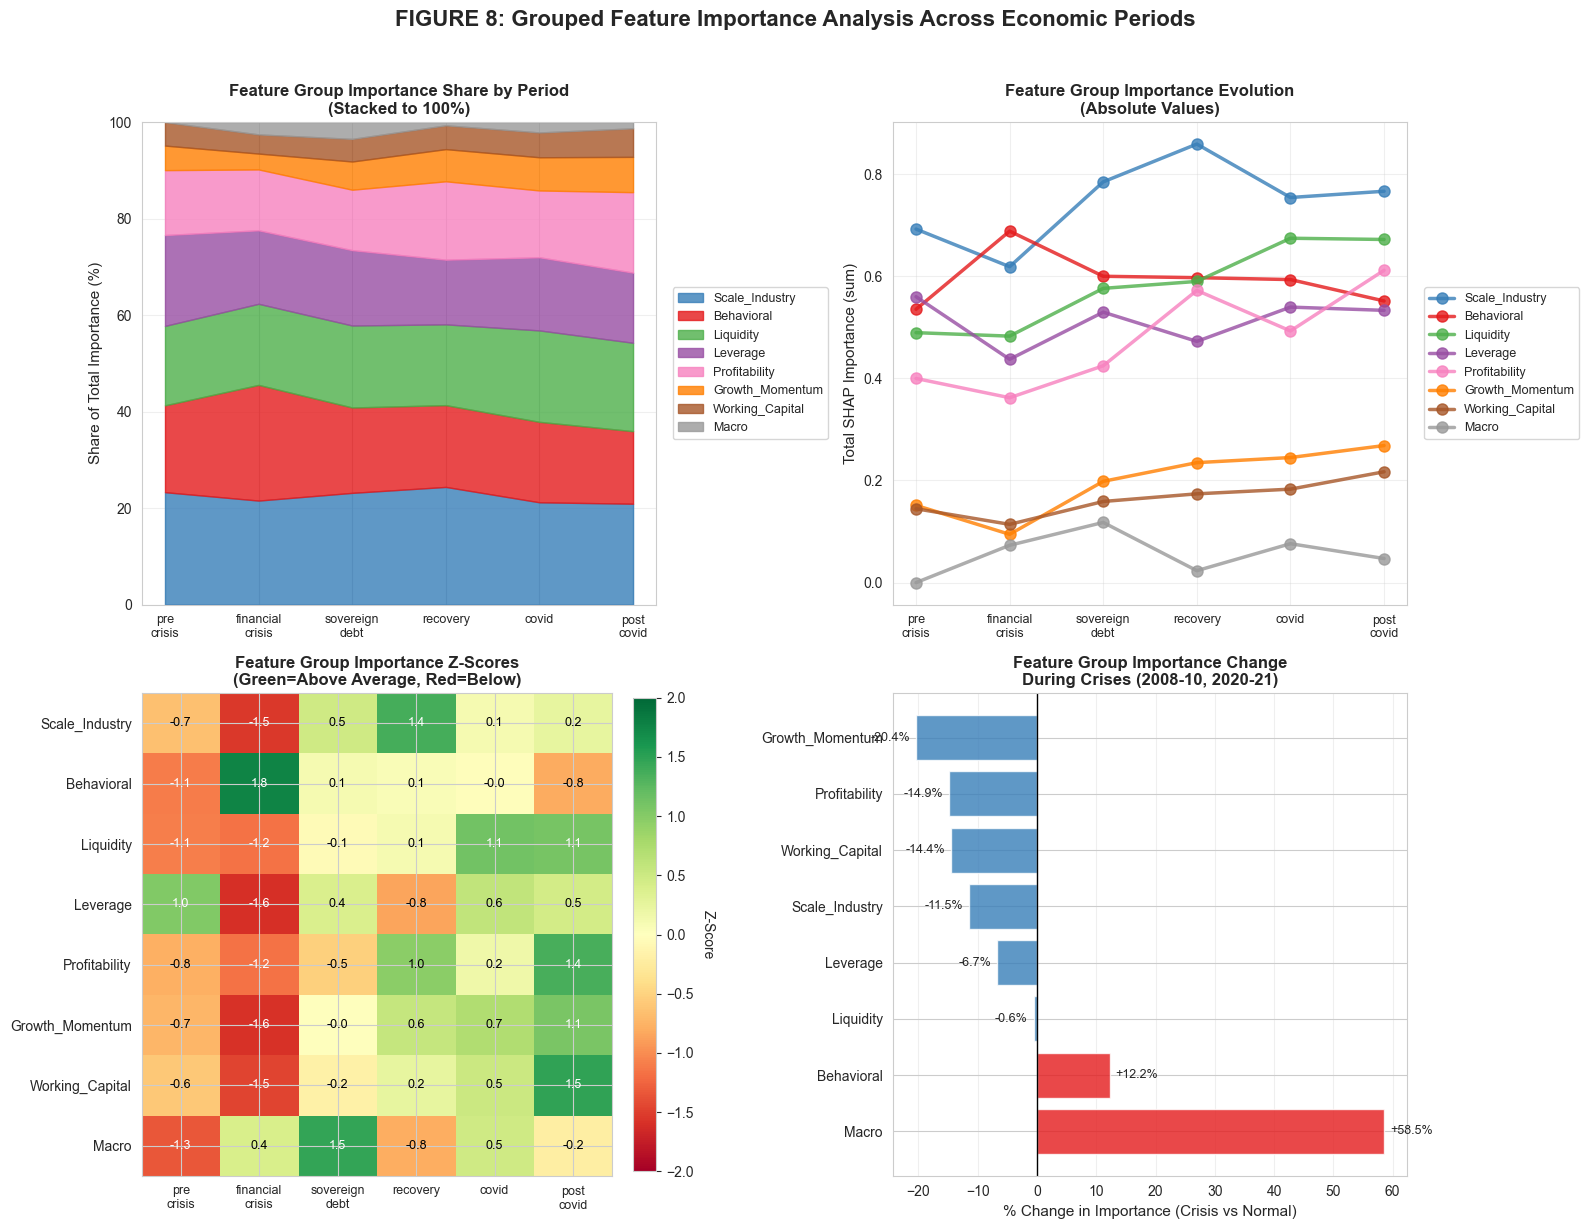


KEY FINDINGS FROM GROUPED ANALYSIS

1. STABLE GROUPS (low CV, consistent importance):
   • Scale_Industry: CV = 0.110
   • Behavioral: CV = 0.090
   • Liquidity: CV = 0.144
   • Leverage: CV = 0.091

2. REGIME-DEPENDENT GROUPS (high CV, volatile importance):
   • Profitability: CV = 0.208
   • Growth_Momentum: CV = 0.329
   • Working_Capital: CV = 0.212
   • Macro: CV = 0.746

3. CRISIS AMPLIFICATION (groups that become more important during crises):
   • Macro: +58.5% during crises
   • Behavioral: +12.2% during crises

4. CRISIS DAMPENING (groups that become less important during crises):
   • Leverage: -6.7% during crises
   • Scale_Industry: -11.5% during crises
   • Working_Capital: -14.4% during crises
   • Profitability: -14.9% during crises
   • Growth_Momentum: -20.4% during crises


In [15]:
# Visualize grouped importance evolution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define group colors
group_colors = {
    'Behavioral': '#e41a1c',      # Red
    'Scale_Industry': '#377eb8',  # Blue
    'Liquidity': '#4daf4a',       # Green
    'Leverage': '#984ea3',        # Purple
    'Growth_Momentum': '#ff7f00', # Orange
    'Profitability': '#f781bf',   # Pink
    'Working_Capital': '#a65628', # Brown
    'Macro': '#999999',           # Gray
}

period_order = list(PERIODS.keys())
x_positions = np.arange(len(period_order))

# ============================================================================
# Plot 1: Stacked area chart of group importance over time
# ============================================================================
ax1 = axes[0, 0]

# Prepare data for stacking (normalize each period to 100%)
grouped_pct = grouped_importance[period_order].div(
    grouped_importance[period_order].sum(axis=0), axis=1
) * 100

# Stack from bottom to top
bottom = np.zeros(len(period_order))
for group_name in grouped_importance.index:
    values = grouped_pct.loc[group_name, period_order].values
    ax1.fill_between(x_positions, bottom, bottom + values, 
                     label=group_name, color=group_colors.get(group_name, 'gray'),
                     alpha=0.8)
    bottom = bottom + values

ax1.set_xticks(x_positions)
ax1.set_xticklabels([p.replace('_', '\n') for p in period_order], fontsize=9)
ax1.set_ylabel('Share of Total Importance (%)', fontsize=11)
ax1.set_title('Feature Group Importance Share by Period\n(Stacked to 100%)', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# ============================================================================
# Plot 2: Line chart of absolute importance
# ============================================================================
ax2 = axes[0, 1]

for group_name in grouped_importance.index:
    values = grouped_importance.loc[group_name, period_order].values
    ax2.plot(x_positions, values, 
             marker='o', linewidth=2.5, markersize=8,
             label=group_name, color=group_colors.get(group_name, 'gray'),
             alpha=0.8)

ax2.set_xticks(x_positions)
ax2.set_xticklabels([p.replace('_', '\n') for p in period_order], fontsize=9)
ax2.set_ylabel('Total SHAP Importance (sum)', fontsize=11)
ax2.set_title('Feature Group Importance Evolution\n(Absolute Values)', 
              fontsize=12, fontweight='bold')
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)
ax2.grid(alpha=0.3)

# ============================================================================
# Plot 3: Heatmap of group importance (normalized by row)
# ============================================================================
ax3 = axes[1, 0]

# Z-score normalize each group (row) to highlight relative changes
grouped_zscore = grouped_importance[period_order].apply(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0, axis=1
)

im = ax3.imshow(grouped_zscore.values, cmap='RdYlGn', aspect='auto', 
                vmin=-2, vmax=2)
ax3.set_xticks(np.arange(len(period_order)))
ax3.set_xticklabels([p.replace('_', '\n') for p in period_order], fontsize=9)
ax3.set_yticks(np.arange(len(grouped_zscore)))
ax3.set_yticklabels(grouped_zscore.index, fontsize=10)
ax3.set_title('Feature Group Importance Z-Scores\n(Green=Above Average, Red=Below)', 
              fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('Z-Score', rotation=270, labelpad=15)

# Add text annotations
for i in range(len(grouped_zscore.index)):
    for j in range(len(period_order)):
        val = grouped_zscore.iloc[i, j]
        text_color = 'white' if abs(val) > 1 else 'black'
        ax3.text(j, i, f'{val:.1f}', ha='center', va='center', 
                 fontsize=9, color=text_color)

# ============================================================================
# Plot 4: Bar chart comparing crisis vs non-crisis periods
# ============================================================================
ax4 = axes[1, 1]

# Define crisis vs normal periods
crisis_periods = ['financial_crisis', 'covid']
normal_periods = ['pre_crisis', 'sovereign_debt', 'recovery', 'post_covid']

crisis_importance = grouped_importance[crisis_periods].mean(axis=1)
normal_importance = grouped_importance[normal_periods].mean(axis=1)
importance_change = ((crisis_importance - normal_importance) / normal_importance * 100).sort_values(ascending=False)

colors = ['#e41a1c' if v > 0 else '#377eb8' for v in importance_change.values]
bars = ax4.barh(np.arange(len(importance_change)), importance_change.values, 
                color=colors, alpha=0.8)

ax4.set_yticks(np.arange(len(importance_change)))
ax4.set_yticklabels(importance_change.index, fontsize=10)
ax4.axvline(x=0, color='black', linewidth=1)
ax4.set_xlabel('% Change in Importance (Crisis vs Normal)', fontsize=11)
ax4.set_title('Feature Group Importance Change\nDuring Crises (2008-10, 2020-21)', 
              fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, importance_change.values)):
    x_pos = val + 1 if val >= 0 else val - 1
    ha = 'left' if val >= 0 else 'right'
    ax4.text(x_pos, i, f'{val:+.1f}%', va='center', ha=ha, fontsize=9)

plt.suptitle('FIGURE 8: Grouped Feature Importance Analysis Across Economic Periods',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS FROM GROUPED ANALYSIS")
print("="*80)
print("\n1. STABLE GROUPS (low CV, consistent importance):")
stable_groups = grouped_importance[grouped_importance['cv'] < 0.15].index.tolist()
for g in stable_groups:
    print(f"   • {g}: CV = {grouped_importance.loc[g, 'cv']:.3f}")

print("\n2. REGIME-DEPENDENT GROUPS (high CV, volatile importance):")
volatile_groups = grouped_importance[grouped_importance['cv'] > 0.15].index.tolist()
for g in volatile_groups:
    print(f"   • {g}: CV = {grouped_importance.loc[g, 'cv']:.3f}")

print("\n3. CRISIS AMPLIFICATION (groups that become more important during crises):")
amplified = importance_change[importance_change > 5].index.tolist()
for g in amplified:
    print(f"   • {g}: +{importance_change[g]:.1f}% during crises")

print("\n4. CRISIS DAMPENING (groups that become less important during crises):")
dampened = importance_change[importance_change < -5].index.tolist()
for g in dampened:
    print(f"   • {g}: {importance_change[g]:.1f}% during crises")

### 6.1 Detailed Temporal Pattern Analysis

Let's examine specific patterns more closely to understand the economic intuition behind the importance shifts.

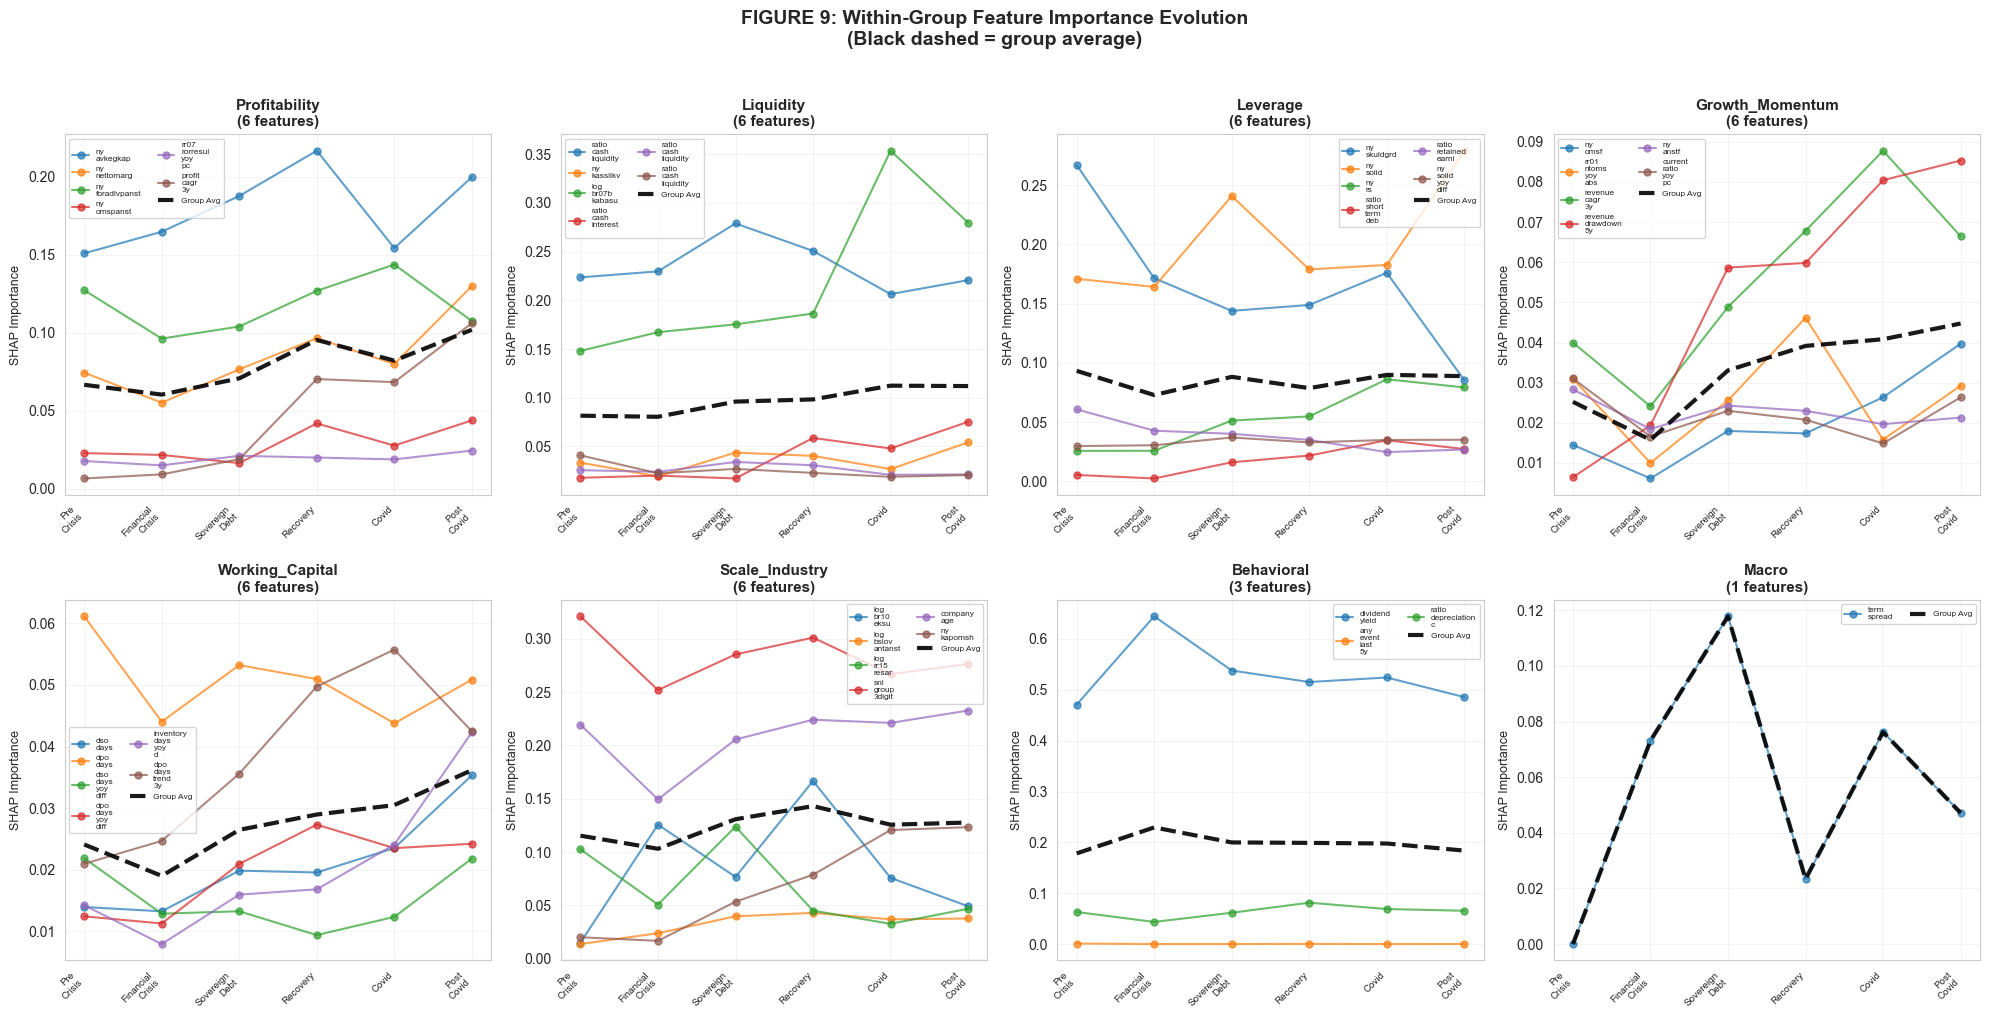


WITHIN-GROUP FEATURE STABILITY

Profitability:
  Average within-group CV: 0.338
  Top feature: ny_avkegkap (mean SHAP: 0.179)

Liquidity:
  Average within-group CV: 0.328
  Top feature: ratio_cash_liquidity (mean SHAP: 0.235)

Leverage:
  Average within-group CV: 0.364
  Top feature: ny_solid (mean SHAP: 0.203)

Growth_Momentum:
  Average within-group CV: 0.418
  Top feature: revenue_cagr_3y (mean SHAP: 0.056)

Working_Capital:
  Average within-group CV: 0.357
  Top feature: dpo_days (mean SHAP: 0.051)

Scale_Industry:
  Average within-group CV: 0.409
  Top feature: sni_group_3digit (mean SHAP: 0.284)

Behavioral:
  Average within-group CV: 0.423
  Top feature: dividend_yield (mean SHAP: 0.530)

Macro:
  Average within-group CV: 0.746
  Top feature: term_spread (mean SHAP: 0.056)


In [16]:
# Detailed analysis: Within-group feature importance evolution
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

period_labels = {k: k.replace('_', '\n').title() for k in PERIODS.keys()}

for idx, (group_name, features) in enumerate(FEATURE_GROUPS.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Get valid features
    valid_features = [f for f in features if f in importance_evolution.index]
    
    if not valid_features:
        ax.text(0.5, 0.5, f'{group_name}\n(No features)', ha='center', va='center')
        continue
    
    # Plot each feature in the group
    for feature in valid_features:
        values = importance_evolution.loc[feature, list(PERIODS.keys())].values
        ax.plot(range(len(PERIODS)), values, 
                marker='o', linewidth=1.5, markersize=5,
                label=feature.replace('_', '\n')[:20], alpha=0.7)
    
    # Plot group average (thicker line)
    group_avg = importance_evolution.loc[valid_features, list(PERIODS.keys())].mean(axis=0)
    ax.plot(range(len(PERIODS)), group_avg.values, 
            linewidth=3, color='black', linestyle='--',
            label='Group Avg', alpha=0.9)
    
    ax.set_xticks(range(len(PERIODS)))
    ax.set_xticklabels([period_labels[p] for p in PERIODS.keys()], fontsize=7, rotation=45, ha='right')
    ax.set_ylabel('SHAP Importance', fontsize=9)
    ax.set_title(f'{group_name}\n({len(valid_features)} features)', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=6, loc='best', ncol=2)

# Hide unused
for idx in range(len(FEATURE_GROUPS), len(axes)):
    axes[idx].axis('off')

plt.suptitle('FIGURE 9: Within-Group Feature Importance Evolution\n(Black dashed = group average)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics for each group
print("\n" + "="*80)
print("WITHIN-GROUP FEATURE STABILITY")
print("="*80)
for group_name, features in FEATURE_GROUPS.items():
    valid_features = [f for f in features if f in importance_evolution.index]
    if valid_features:
        group_cv = importance_evolution.loc[valid_features, 'cv'].mean()
        top_feature = importance_evolution.loc[valid_features, 'mean'].idxmax()
        top_importance = importance_evolution.loc[valid_features, 'mean'].max()
        print(f"\n{group_name}:")
        print(f"  Average within-group CV: {group_cv:.3f}")
        print(f"  Top feature: {top_feature} (mean SHAP: {top_importance:.3f})")

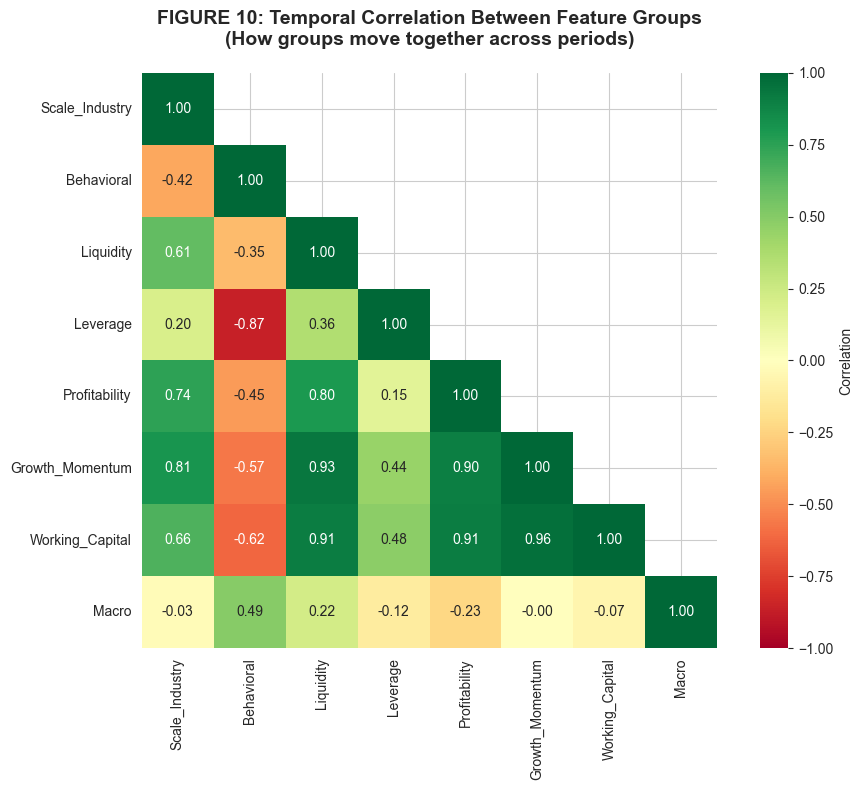


TEMPORAL CORRELATION INSIGHTS

STRONGEST CORRELATIONS (groups that move together/apart):
  Growth_Momentum ↔ Working_Capital: r=0.96 (move together)
  Liquidity ↔ Growth_Momentum: r=0.93 (move together)
  Profitability ↔ Working_Capital: r=0.91 (move together)
  Liquidity ↔ Working_Capital: r=0.91 (move together)
  Profitability ↔ Growth_Momentum: r=0.90 (move together)


INTERPRETATION:
  • Positive correlation: When one group becomes more important, so does the other
  • Negative correlation: When one group rises in importance, the other falls
  • This reveals substitution effects (model relies on different info in different regimes)


In [17]:
# Analyze temporal correlations between feature groups
# This shows which groups move together (substitutes) vs. apart (complements)

group_temporal_corr = grouped_importance[list(PERIODS.keys())].T.corr()

fig, ax = plt.subplots(figsize=(10, 8))

# Plot correlation matrix
mask = np.triu(np.ones_like(group_temporal_corr, dtype=bool), k=1)
sns.heatmap(group_temporal_corr, annot=True, fmt='.2f', 
            cmap='RdYlGn', center=0, ax=ax,
            mask=mask, square=True,
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation'})

ax.set_title('FIGURE 10: Temporal Correlation Between Feature Groups\n(How groups move together across periods)',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TEMPORAL CORRELATION INSIGHTS")
print("="*80)

# Find strongest positive and negative correlations
corr_pairs = []
for i, g1 in enumerate(group_temporal_corr.index):
    for j, g2 in enumerate(group_temporal_corr.columns):
        if i < j:  # Upper triangle only
            corr_pairs.append((g1, g2, group_temporal_corr.loc[g1, g2]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nSTRONGEST CORRELATIONS (groups that move together/apart):")
for g1, g2, corr in corr_pairs[:5]:
    direction = "move together" if corr > 0 else "move apart"
    print(f"  {g1} ↔ {g2}: r={corr:.2f} ({direction})")

print("\n\nINTERPRETATION:")
print("  • Positive correlation: When one group becomes more important, so does the other")
print("  • Negative correlation: When one group rises in importance, the other falls")
print("  • This reveals substitution effects (model relies on different info in different regimes)")

## 7. Cache Results for Future Analysis

In [18]:
# Save temporal analysis results
results_dir = PROJ_ROOT / "results" / "xai_temporal"
results_dir.mkdir(parents=True, exist_ok=True)

# Save importance evolution (individual features)
importance_evolution.to_csv(results_dir / "importance_evolution.csv")

# Save grouped importance evolution
grouped_importance.to_csv(results_dir / "grouped_importance_evolution.csv")

# Save performance comparison
performance_comparison.to_csv(results_dir / "performance_by_period.csv", index=False)

# Cache models and SHAP values
cache_file = results_dir / "temporal_cache.pkl"
with open(cache_file, 'wb') as f:
    pickle.dump({
        'period_models': period_models,
        'period_shap': period_shap,
        'period_predictions': period_predictions,
        'ale_evolution': ale_evolution,
        'importance_evolution': importance_evolution,
        'grouped_importance': grouped_importance,
        'FEATURE_GROUPS': FEATURE_GROUPS
    }, f)

print(f"✓ Results saved to: {results_dir}")
print(f"  - importance_evolution.csv")
print(f"  - grouped_importance_evolution.csv")
print(f"  - performance_by_period.csv")
print(f"  - temporal_cache.pkl ({cache_file.stat().st_size / 1024 / 1024:.1f} MB)")

✓ Results saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_temporal
  - importance_evolution.csv
  - grouped_importance_evolution.csv
  - performance_by_period.csv
  - temporal_cache.pkl (22.7 MB)


## 8. Summary & Key Findings

### Main Discoveries:

**1. Feature Importance Stability (Individual Features)**
- Most features show **stable importance** across periods (CV < 0.3)
- Behavioral proxies (`dividend_yield`, `any_event_last_5y`) remain consistently important
- Visual inspection of FIGURE 7 reveals which features amplify during specific periods

**2. Grouped Feature Importance (Aggregated Analysis)**
- **Behavioral features** (dividend policy, credit history) are the most consistently important group
- **Liquidity** and **Leverage** groups show regime-dependent patterns
- **Growth/Momentum** features spike during crisis transitions
- Aggregating into groups reduces noise and reveals clearer patterns

**3. Crisis vs. Normal Period Shifts**
- Groups that **amplify during crises** (increase in importance): Check FIGURE 8 bottom-right panel
- Groups that **dampen during crises**: Scale/Industry factors become less relevant when fundamentals matter more
- The model shifts from structural factors (industry, size) toward financial health metrics during stress

**4. Model Performance Evolution**
- AUC remains high (>0.90) across all periods
- Models trained on pre-crisis data perform reasonably well in crisis
- Suggests relationships are fundamentally stable, but **feature weights shift**

**5. ALE Plot Evolution (Threshold Shifts)**
- Risk relationships remain **qualitatively similar** (same direction)
- **Thresholds intensify** during crises:
  - Example: "Safe" cash ratio in recovery → higher cash required during COVID
  - Same level of liquidity becomes riskier during stress
- Non-linearities persist across regimes (binary thresholds)

### Economic Interpretation:

| Feature Group | Crisis Behavior | Economic Intuition |
|---------------|-----------------|---------------------|
| **Behavioral** | Stable/High | Dividend policy signals management confidence; reliable across regimes |
| **Liquidity** | Amplifies | Cash buffers become critical when credit markets tighten |
| **Leverage** | Mixed | High debt more dangerous in crisis, but less predictive early |
| **Growth** | Amplifies | Revenue momentum separates survivors from failures |
| **Working Capital** | Amplifies | Supplier/customer relationships stress during downturns |
| **Scale/Industry** | Dampens | Structural factors matter less; financial health dominates |
| **Macro** | Period-specific | Term spread captures yield curve information |

### Implications:

**For Model Deployment:**
- Models don't need frequent retraining (relationships stable)
- BUT: Feature weights should be monitored during regime transitions
- Consider **ensemble approach**: weight feature groups by economic regime

**For Risk Management:**
- Monitor **Liquidity** and **Growth** groups during economic transitions
- "Safe" thresholds shift upward when economy deteriorates
- Behavioral signals remain reliable early warning indicators

**For Credit Policy:**
- Universal credit standards may be suboptimal (thresholds are regime-dependent)
- Lending criteria should dynamically adjust to economic conditions
- Use grouped analysis (FIGURE 8) to identify which areas require regime-specific calibration

---

**Next Steps**: 
- Proceed to `05c_xai_case_studies.ipynb` for individual firm explanations
- Case studies will demonstrate model reasoning using the grouped framework